**Version 2**:
1. Fixed ranges of Aspect and Hillshade columns
2. Used RobustScaler instead of MinMaxScaler

**Version 3**:
1. Used 20 folds rather than 10 :p
2. Used soft voting instead of hard voting

Please consider **UPVOTING** If you like this notebook :)

 # Part 1: Reading data and preprocessing

In [1]:
import numpy as np
import pandas as pd


pd.set_option("display.max_columns", None)

train_df = pd.read_csv("../input/tabular-playground-series-dec-2021/train.csv")
test_df = pd.read_csv("../input/tabular-playground-series-dec-2021/test.csv")
sub_df = pd.read_csv("../input/tabular-playground-series-dec-2021/sample_submission.csv")

train_df.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,0,3189,40,8,30,13,3270,206,234,193,4873,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,1,3026,182,5,280,29,3270,233,240,106,5423,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2
2,2,3106,13,7,351,37,2914,208,234,137,5269,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,3,3022,276,13,192,16,3034,207,238,156,2866,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2
4,4,2906,186,13,266,22,2916,231,231,154,2642,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2


Dropping the **Id** column from both train and test datasets.

In [2]:
train_df.drop("Id", axis=1, inplace=True)
test_df.drop("Id", axis=1, inplace=True)

Dropping columns **Soil_Type7** and **Soil_Type15** because all the rows in these column have the same value.

In [3]:
cols = ["Soil_Type7", "Soil_Type15"]

train_df.drop(cols, axis=1, inplace=True)
test_df.drop(cols, axis=1, inplace=True)

Dropping the row with **Cover_Type**=5 because there is only a single row corresponding to it.

In [4]:
idx = train_df[train_df["Cover_Type"] == 5].index
train_df.drop(idx, axis=0, inplace=True)

Renaming some columns with long names

In [5]:
new_names = {
    "Horizontal_Distance_To_Hydrology": "x_dist_hydrlgy",
    "Vertical_Distance_To_Hydrology": "y_dist_hydrlgy",
    "Horizontal_Distance_To_Roadways": "x_dist_rdwys",
    "Horizontal_Distance_To_Fire_Points": "x_dist_firepts"
}

train_df.rename(new_names, axis=1, inplace=True)
test_df.rename(new_names, axis=1, inplace=True)

Encoding all the labels so that they range from 0 to 5.

In [6]:
from sklearn.preprocessing import LabelEncoder


encoder = LabelEncoder()
train_df["Cover_Type"] = encoder.fit_transform(train_df["Cover_Type"])

# Part 2: Feature Engineering

**Aspect** is the compass direction that a terrain faces. Here, It is expressed in degrees. All the values from 0 to 359 are present. Besides, there are some values greater than 359 and some smaller than 0. It will be better If we make all the values in this column lie in the range (0, 359). Moreover, all the values in this column lies in the range (-360, 720) so adding 360 to angles smaller than 0 and subtracting 360 from angles greater than 359 will do the work.

In [7]:
train_df["Aspect"][train_df["Aspect"] < 0] += 360
train_df["Aspect"][train_df["Aspect"] > 359] -= 360

test_df["Aspect"][test_df["Aspect"] < 0] += 360
test_df["Aspect"][test_df["Aspect"] > 359] -= 360

Creating distance based features from **Horizontal_Distance_To_Hydrology** and **Vertical_Distance_To_Hydrology**.

In [8]:
# Manhhattan distance to Hydrology
train_df["mnhttn_dist_hydrlgy"] = np.abs(train_df["x_dist_hydrlgy"]) + np.abs(train_df["y_dist_hydrlgy"])
test_df["mnhttn_dist_hydrlgy"] = np.abs(test_df["x_dist_hydrlgy"]) + np.abs(test_df["y_dist_hydrlgy"])

# Euclidean distance to Hydrology
train_df["ecldn_dist_hydrlgy"] = (train_df["x_dist_hydrlgy"]**2 + train_df["y_dist_hydrlgy"]**2)**0.5
test_df["ecldn_dist_hydrlgy"] = (test_df["x_dist_hydrlgy"]**2 + test_df["y_dist_hydrlgy"]**2)**0.5

Creating the following new features:
1. Sum of all the soil types
2. Sum of all the wilderness area types

These features are borrowed from this discussion topic: https://www.kaggle.com/c/tabular-playground-series-dec-2021/discussion/292823

In [9]:
soil_features = [x for x in train_df.columns if x.startswith("Soil_Type")]
train_df["soil_type_count"] = train_df[soil_features].sum(axis=1)
test_df["soil_type_count"] = test_df[soil_features].sum(axis=1)

wilderness_features = [x for x in train_df.columns if x.startswith("Wilderness_Area")]
train_df["wilderness_area_count"] = train_df[wilderness_features].sum(axis=1)
test_df["wilderness_area_count"] = test_df[wilderness_features].sum(axis=1)

A quick Google search about **Hillshade** leads to the following result:

> Hillshading computes surface illumination as values from 0 to 255 based on a given compass direction to the sun (azimuth) and a certain altitude above the horizon (altitude). Hillshades are often used to produce maps that are visually appealing.

Thus, hillshade is a 3D representation of a terrain which is used to gain insight about its form by measuring luminosity of certain patches of that terrain that results when a source of light is casted at a particular angle.

More Information about hillshade [here](http://www.geography.hunter.cuny.edu/~jochen/gtech361/lectures/lecture11/concepts/hillshade.htm#:~:text=Hillshading%20computes%20surface%20illumination%20as,maps%20that%20are%20visually%20appealing.)

In both train and test datasets, there are certain rows with hillshade value more than 255 or less than 0. They must be the result of recording error and should be relpaced with an appropriate value. Perhaps, values less than 0 refer to the darkest shade and replacing them with 0 should be fine. Similarly, we can assume that hillshade values more than 255 refer to the brightest shades and a value of 255 should be good replacement.

In [10]:
train_df.loc[train_df["Hillshade_9am"] < 0, "Hillshade_9am"] = 0
test_df.loc[test_df["Hillshade_9am"] < 0, "Hillshade_9am"] = 0

train_df.loc[train_df["Hillshade_Noon"] < 0, "Hillshade_Noon"] = 0
test_df.loc[test_df["Hillshade_Noon"] < 0, "Hillshade_Noon"] = 0

train_df.loc[train_df["Hillshade_3pm"] < 0, "Hillshade_3pm"] = 0
test_df.loc[test_df["Hillshade_3pm"] < 0, "Hillshade_3pm"] = 0

train_df.loc[train_df["Hillshade_9am"] > 255, "Hillshade_9am"] = 255
test_df.loc[test_df["Hillshade_9am"] > 255, "Hillshade_9am"] = 255

train_df.loc[train_df["Hillshade_Noon"] > 255, "Hillshade_Noon"] = 255
test_df.loc[test_df["Hillshade_Noon"] > 255, "Hillshade_Noon"] = 255

train_df.loc[train_df["Hillshade_3pm"] > 255, "Hillshade_3pm"] = 255
test_df.loc[test_df["Hillshade_3pm"] > 255, "Hillshade_3pm"] = 255

Scaling with RobustScaler

In [11]:
from sklearn.preprocessing import RobustScaler


cols = [
    "Elevation",
    "Aspect",
    "mnhttn_dist_hydrlgy",
    "ecldn_dist_hydrlgy",
    "soil_type_count",
    "wilderness_area_count",
    "Slope",
    "x_dist_hydrlgy",
    "y_dist_hydrlgy",
    "x_dist_rdwys",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "x_dist_firepts",
    "soil_type_count",
    "wilderness_area_count"
]

scaler = RobustScaler()
train_df[cols] = scaler.fit_transform(train_df[cols])
test_df[cols] = scaler.transform(test_df[cols])

Reducing the size of train and test dataframes

In [12]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df

In [13]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Mem. usage decreased to 537.17 Mb (71.7% reduction)
Mem. usage decreased to 93.46 Mb (78.1% reduction)


# Part 3: Modelling with Neural Network

I have used Self-normalizing Neural Networks here which is described in this notebook: https://www.kaggle.com/gulshanmishra/self-normalizing-neural-networks

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization


INPUT_SHAPE = test_df.shape[1:]
NUM_CLASSES = train_df["Cover_Type"].nunique()

def build_model():
    model = Sequential([
        Dense(units=300, kernel_initializer="lecun_normal", activation="selu", input_shape=INPUT_SHAPE),
        BatchNormalization(),
        Dense(units=200, kernel_initializer="lecun_normal", activation="selu"),
        BatchNormalization(),
        Dense(units=100, kernel_initializer="lecun_normal", activation="selu"),
        BatchNormalization(),
        Dense(units=50, kernel_initializer="lecun_normal", activation="selu"),
        BatchNormalization(),
        Dense(units=NUM_CLASSES, activation="softmax")
    ])

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

Callbacks for early stopping and learning rate reduction when it "plateaus"

In [15]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5
)

early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=20,
    restore_best_weights=True
)

callbacks = [reduce_lr, early_stop]

In [16]:
build_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               17100     
_________________________________________________________________
batch_normalization (BatchNo (None, 300)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 200)               60200     
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5

2021-12-06 16:16:38.324103: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-06 16:16:38.430077: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-06 16:16:38.430790: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-06 16:16:38.431984: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

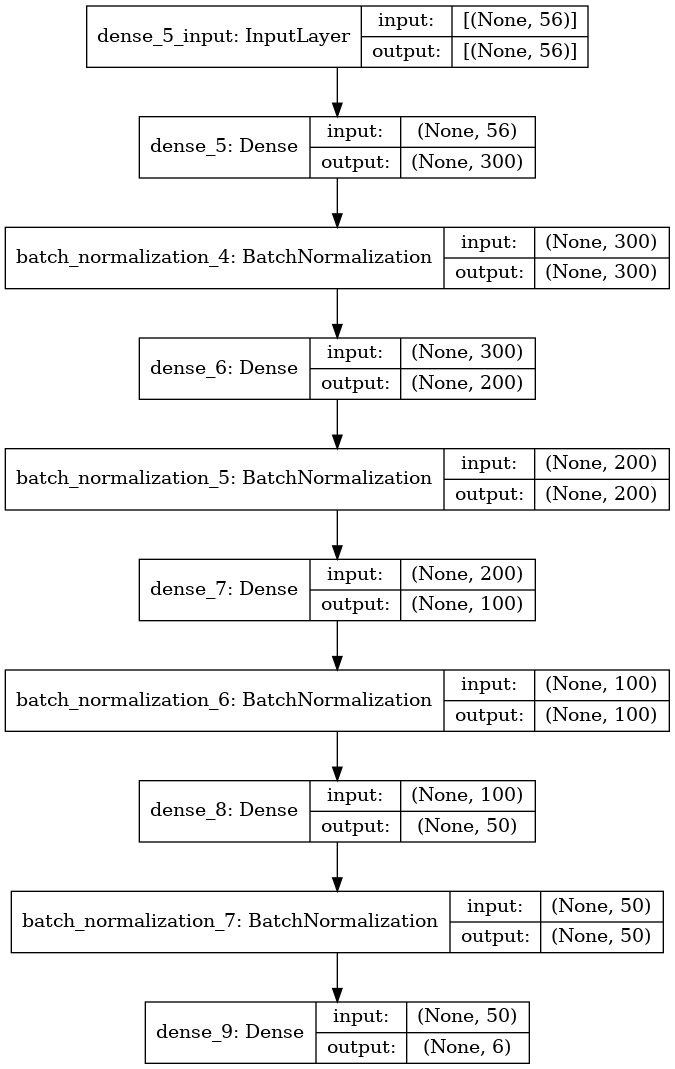

In [17]:
from tensorflow.keras.utils import plot_model


plot_model(
    build_model(),
    show_shapes=True,
    show_layer_names=True
)

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score


X = train_df.drop("Cover_Type", axis=1).values
y = train_df["Cover_Type"].values

del train_df

FOLDS = 20
EPOCHS = 200
BATCH_SIZE = 2048

test_preds = np.zeros((1, 1))
scores = []

cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = build_model()
    model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=False
    )

    y_pred = np.argmax(model.predict(X_val), axis=1)
    score = accuracy_score(y_val, y_pred)
    scores.append(score)

    test_preds = test_preds + model.predict(test_df)
    print(f"Fold {fold} Accuracy: {score}")

print()
print(f"Mean Accuracy: {np.mean(scores)}")

2021-12-06 16:16:43.675565: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 851199776 exceeds 10% of free system memory.
2021-12-06 16:16:44.559266: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 851199776 exceeds 10% of free system memory.
2021-12-06 16:16:45.191698: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Fold 0 Accuracy: 0.962255


2021-12-06 16:24:57.675309: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 851199776 exceeds 10% of free system memory.
2021-12-06 16:24:58.620698: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 851199776 exceeds 10% of free system memory.


Fold 1 Accuracy: 0.962875


2021-12-06 16:36:11.404025: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 851199776 exceeds 10% of free system memory.


Fold 2 Accuracy: 0.962365
Fold 3 Accuracy: 0.96222
Fold 4 Accuracy: 0.96227
Fold 5 Accuracy: 0.96298
Fold 6 Accuracy: 0.962855
Fold 7 Accuracy: 0.96271
Fold 8 Accuracy: 0.962065
Fold 9 Accuracy: 0.96262
Fold 10 Accuracy: 0.96181
Fold 11 Accuracy: 0.962565
Fold 12 Accuracy: 0.9623
Fold 13 Accuracy: 0.96277
Fold 14 Accuracy: 0.962305
Fold 15 Accuracy: 0.96228
Fold 16 Accuracy: 0.962265
Fold 17 Accuracy: 0.962305
Fold 18 Accuracy: 0.96148
Fold 19 Accuracy: 0.96239981199906

Mean Accuracy: 0.962384740599953


Using soft voting strategy to ensemble test predictions

In [19]:
test_preds = np.argmax(test_preds, axis=1)
test_preds = encoder.inverse_transform(test_preds)

sub_df['Cover_Type'] = test_preds
sub_df.head()

,Id,Cover_Type
0,4000000,2
1,4000001,2
2,4000002,2
3,4000003,2
4,4000004,2


In [20]:
sub_df.to_csv("submission.csv", index=False)